## PRUEBA NOTEBOOK

In [1]:
import bz2
import csv
import os
import requests

import pandas as pd
import numpy as np

import sqlite3
import sqlalchemy

import matplotlib.pyplot as plt
import seaborn as sns

from typing import List
from pandas.io import sql

LOCAL_DATA_PATH = os.path.join(os.getcwd(), 'data')

base_url = 'https://gist.github.com/juanriaza/9b6f7ab3fc1cbda81100fa5d32512fd8/raw/a61db2d8d81789d5c7040eacee7b225bc2b2aa7f'
file_name = 'data.csv.bz2'

url = os.path.join(base_url, file_name)
url

'https://gist.github.com/juanriaza/9b6f7ab3fc1cbda81100fa5d32512fd8/raw/a61db2d8d81789d5c7040eacee7b225bc2b2aa7f/data.csv.bz2'

### Download the data from the provided link

In [2]:
DATA_DELIMITER = '|'
DATA_ENCODING = 'utf-8'

def fetch_data(url:str) -> List:
    """ Given an url with bz2 file and a target directory, this function makes a
    GET request to the file and decompress it.

    It handles the following cases:
        - Get request status has to be <200> Ok
        - The is data within the BZ2

    Args:
        url (str) : location of file to download
    
    Returns: 
        data (list) : list of rows as string
    """

    rq = requests.get(url)   

    if rq.status_code == 200:
        data = bz2.decompress(rq.content).decode(DATA_ENCODING).splitlines()

        assert len(data) >0, f"No data in file : {url}"
        return data

    else:
        raise FileNotFoundError
    

def write_to_csv(data:list, fname:str) -> None:
    """ Given a list of rows, writes a CSV file in the target directory with the 
    specified name.

    It handles the following cases:
        - Checks the target directory exists or it creates it
        - Checks the output file has .CSV as extention, if not, it adds it.

    Args:
        data (list)
        target_dir (str)
        fname (str)
    
    Returns
        None
    """
    if not os.path.exists(LOCAL_DATA_PATH):
        os.mkdir(LOCAL_DATA_PATH)
        
    if not fname.endswith('.csv'):
        fname += '.csv'

    i = 0
    path = os.path.join(LOCAL_DATA_PATH, fname)

    with open(path, 'w') as f:
        writer = csv.writer(f, delimiter = ',', strict=True)

        for row in data:
            try:
                row = row.split(DATA_DELIMITER)
                writer.writerow(row)
                i +=1

            except Exception as e:
                # needs development
                print(e)

    print(f"Written {i} lines at : {path}")


In [4]:
write_to_csv(
    data = fetch_data(url),
    fname = 'data.csv'
)

Written 122375 lines at : /home/laura/Pruebas/technical_test/data/data.csv


In [3]:
# let's print the columns the make easier the table creation below
columns = []
with open(os.path.join(LOCAL_DATA_PATH, 'data.csv'), 'r') as f:
    reader = csv.reader(f, delimiter = DATA_DELIMITER)

    for i, row in enumerate(reader):        
        if i== 0: 
            columns = row[0].split(',')
            for col in row:
                print(col)

customer_id,city,typology,subtypology,transaction_type,price,zipcode,bedrooms,bathrooms,area,area_land,is_professional,date_added


### Set up a SQLite database locally and ingest the CSV file

Before this, the database has been created through the command line as indicated. See more at the README.

Once the data has been ingested into the database, we make the asked queries using sqlite3.

In [5]:
connector = sqlite3.connect("database.db")
cursor = connector.cursor()

_df = pd.read_csv("data/data.csv", sep=',', dtype={'zipcode':'object'})
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122374 entries, 0 to 122373
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   customer_id       122374 non-null  object
 1   city              122374 non-null  object
 2   typology          122374 non-null  object
 3   subtypology       122374 non-null  object
 4   transaction_type  122374 non-null  object
 5   price             122374 non-null  int64 
 6   zipcode           122374 non-null  object
 7   bedrooms          122374 non-null  int64 
 8   bathrooms         122374 non-null  int64 
 9   area              122374 non-null  int64 
 10  area_land         122374 non-null  int64 
 11  is_professional   122374 non-null  int64 
 12  date_added        122374 non-null  object
dtypes: int64(6), object(7)
memory usage: 12.1+ MB


##### * Num rental properties from each client by postal code

In [45]:
res = cursor.execute(
    """
    SELECT 
        customer_id,
        zipcode,
        COUNT(*)
    FROM t
    WHERE
        transaction_type = 'rent' 
    GROUP BY
        customer_id,
        zipcode        
    ;
    """
)

df_sql = pd.DataFrame(res.fetchall(), columns = ['customer_id', 'zipcode', 'count_total'])\
            .sort_values(by = ['customer_id', 'zipcode'])
df_sql.head()

,customer_id,zipcode,count_total
0,393030303830303030333431,08950,2
1,393030303830303030333431,08960,8
2,393030303830303030333431,08970,1
3,393030313430303030323137,08001,1
4,393030313430303030323137,08003,1


In [46]:
_f = (_df['transaction_type'] == "rent")

df_pandas = _df[_f]\
    .groupby(['customer_id', 'zipcode'])\
    .agg('count')['date_added']\
    .reset_index(drop=False)\
    .rename(columns={'date_added': 'count_total'})\
    .sort_values(by = ['customer_id', 'zipcode'])

df_pandas.head()

,customer_id,zipcode,count_total
0,393030303830303030333431,08950,2
1,393030303830303030333431,08960,8
2,393030303830303030333431,08970,1
3,393030313430303030323137,08001,1
4,393030313430303030323137,08003,1


In [47]:
## assertion : both ways need to result in the same answer
df_sql.equals(df_pandas) 

True

/home/laura/Pruebas/technical_test/.env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


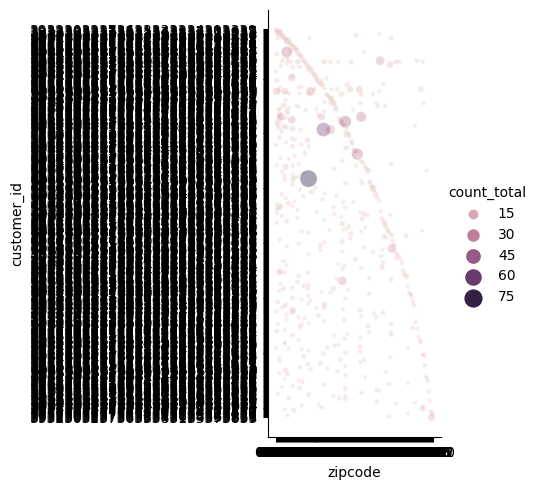

In [60]:
# viz:
# show where each client has properties and how many of them.

sns.relplot(
    x = 'zipcode',
    y = 'customer_id',
    size = 'count_total',
    hue = 'count_total',
    sizes = (10, 150),
    alpha = 0.4,
    data = df_pandas.sample(500)
)

##### * Cheapest and most expensive unitary price (€/m2) by zicode in Barcelona

In [14]:
res = cursor.execute(
    """
    SELECT 
        zipcode,
        MAX(price_by_squaremeter) AS max_price_by_squaremeter,
        MIN(price_by_squaremeter) AS min_price_by_squaremeter
    FROM (
        SELECT 
            zipcode,
            ROUND(price/area, 3) as price_by_squaremeter
        FROM t
        WHERE 
                city like '%Barcelona%'
            and area  > 0
            and price > 0
    ) AS f
    GROUP BY
        zipcode
    ;
    """
)

cols = ['zipcode', 'min_price', 'max_price']
df_sql = pd.DataFrame(res.fetchall(), columns = cols).sort_values(cols)

df_sql

,zipcode,min_price,max_price
0,00000,1850.0,1850.0
1,08001,26428.0,0.0
2,08002,26976.0,1.0
3,08003,13333.0,0.0
4,08004,9111.0,0.0
...,...,...,...
90,8028,5128.0,4193.0
91,8030,5835.0,1544.0
92,8032,6941.0,3828.0
93,88010,19.0,19.0


In [16]:
_f = (_df['city'].str.contains("Barcelona")) &\
     (_df['area']  > 0) &\
     (_df['price'] > 0)

df_pandas = _df[_f].copy(deep=True)
df_pandas['price_by_squaremeter'] = df_pandas[['price', 'area']].apply(
    lambda row: row.iloc[0] / row.iloc[1], axis=1
)

df_pandas = df_pandas\
    .groupby('zipcode')['price_by_squaremeter']\
    .agg(["max", 'min'])\
    .applymap(lambda cell: round(cell, 3))

df_pandas

,max,min
zipcode,,
00000,1850.000,1850.000
08001,26428.571,0.467
08002,26976.190,1.500
08003,13333.333,0.300
08004,9111.111,0.964
...,...,...
8028,5128.205,4193.548
8030,5835.821,1544.715
8032,6941.176,3828.571


In [17]:
# assertion
df_sql.equals(df_pandas)

# sql round when doing unitary price

False

##### * Client with oldest real state portfolio in Barcelona

In [18]:
res = cursor.execute(
    """
    WITH 

    avg_date_from_each_customer AS (
        SELECT 
            customer_id,
            DATETIME(AVG(jdate)) AS avg_date
        FROM (
            SELECT 
                customer_id,
                julianday(date_added) as jdate
            FROM 
                t
            WHERE 
                    city like '%Barcelona%'
                AND is_professional == 1
        ) AS f
        GROUP BY
            customer_id 
    )   

    SELECT 
        *
    FROM 
        avg_date_from_each_customer
    ORDER BY
        avg_date ASC
    LIMIT 
        1
    ;
    """
)

cols = ['customer_id', 'avg_date']
df_sql = pd.DataFrame(res.fetchall(), columns = cols).sort_values(cols)

df_sql['avg_date'] = pd.to_datetime(df_sql['avg_date'])
df_sql

,customer_id,avg_date
0,39323032373532323733363139,2009-10-13 17:40:00


In [19]:

# filters
_f = (_df['city'].str.contains("Barcelona")) &\
     (_df['is_professional'])

df_pandas = _df[_f].copy(deep=True)

# transformations
df_pandas['date_added'] = pd.to_datetime(df_pandas['date_added']).values.astype(np.int64)

df_pandas = df_pandas\
    .groupby('customer_id')['date_added'].agg('mean')\
    .sort_values(ascending=True)\
    .reset_index(drop=False)\
    .iloc[0].to_frame().T\
    .rename(columns = {'date_added': 'avg_date'})

df_pandas['avg_date'] = pd.to_datetime(df_pandas['avg_date'])
df_pandas


,customer_id,avg_date
0,39323032373532323733363139,2009-10-13 17:40:00


In [20]:
df_sql.equals(df_pandas)

True

##### * City with the most expensive SU (Suelo Urbanizable).

In [27]:
res = cursor.execute(
    """
    WITH

    terrains_by_price AS (
        SELECT 
            city,
            typology,
            area_land,
            area,
            price
            
        FROM t
        WHERE 
                typology == 'Terreno' -- SU son terrenos
            and area_land > 0         -- there is land to build
            and area  > 0
            and price > 0
    )

    SELECT 
        city,
        typology,
        area_land,
        price
    FROM terrains_by_price
    ORDER BY 
        price DESC
    LIMIT 1
    ;
    """
)

cols = ['city', 'typology', 'area_land', 'price']
df_sql = pd.DataFrame(res.fetchall(), columns = cols).sort_values(cols)

df_sql

,city,typology,area_land,price
0,Caldes de Montbui,Terreno,26002,5850000


In [28]:
# apply filters
_f = (_df['typology'] == 'Terreno') &\
     (_df['area_land'] > 0) &\
     (_df['area'] > 0) &\
     (_df['price'] > 0)

df_pandas = _df[_f].copy(deep=True)

df_pandas = df_pandas.loc[df_pandas['price'] == df_pandas['price'].max(), :][['city', 'typology', 'area_land', 'price']].reset_index(drop=True)
df_pandas

,city,typology,area_land,price
0,Caldes de Montbui,Terreno,26002,5850000


In [29]:
df_sql.equals(df_pandas)

True

In [6]:
cursor.close()
connector.close()

----

###

An investor wants to know, by zipcode, which properties are interesting, add to the pandas dataframe the following columns:

* over_valued
* normal
* under_valued

----

The approach to this is to classify each row by its IQR :

* over_valued   :  >75%   Percentile
* normal        :  25-75% Percentile 
* under_valued  :  <25%   Percentile

In [34]:
_df['typlogy_general'] = _df[['typology', 'subtypology']].apply(lambda row: " ".join(row).strip().replace('""', ''), axis = 1)
_df['typlogy_general'].value_counts()

typlogy_general
Vivienda Piso                      43411
Vivienda Chalet                    19060
Garaje                             17605
Local comercial                    13992
Vivienda Casa adosada               3584
Oficina                             3304
Vivienda Dúplex                     2980
Vivienda Ático                      2783
Terreno Terreno                     2726
Terreno                             2235
Local comercial Nave Industrial     2059
Vivienda Apartamento                1558
Terreno Terreno Urbanizable         1444
Vivienda Planta baja                1297
Terreno Terreno Residencial         1254
Trastero                            1046
Vivienda Finca rústica               980
Edificio                             493
Vivienda Loft                        338
Vivienda Estudio                     209
Terreno Terreno Industrial             7
Terreno Terreno No Urbanizable         6
Terreno Chalet                         1
Garaje Piso                            1


In [18]:
def compute_unit_price(row): 
    """
    Depending on the property's typology, the unitary price is computed in different ways:
        * Parking spots usually have the same size (they are standarized by car size)
        * The rest, due to the lack of more information, the unitary price is computed by the
        given area, but usually housing, offices and storerooms are differently valuated from 
        buildings and terrains.

    If hte area is zero, a gross imputation is done: 
        * if number of bedrooms and bathrooms is known, we could impute an area
            - each room is about 12m2 and each bathroom is about 3m2
        * there is no information about kitchens and living rooms, but another 10m2 are added

    Args: 
        row 
    
    Returns:
        row
    """

    if row['area'] != 0:
        if row['typology'] in ['Vivienda', 'Local Comercial', 'Oficina', 'Edificio', 'Trastero', 'Terreno']:
            return row['price'] / row['area']

        elif row['typology'] in ['Garaje']:
            return row['price']


_df['unit_price'] = _df[['price', 'typology', 'area', 'bedrooms', 'bathrooms']].apply(lambda row: compute_unit_price(row), axis = 1)
_df[['price', 'unit_price']].describe()

,price,unit_price
count,1.223740e+05,1.033980e+05
mean,9.287925e+05,4.535509e+03
std,2.477246e+07,7.205606e+04
min,0.000000e+00,0.000000e+00
25%,1.350000e+04,8.605608e+02
50%,1.560000e+05,1.975000e+03
75%,3.150000e+05,3.630769e+03
max,1.000000e+09,1.250000e+07


Let's show stats and show the distribution

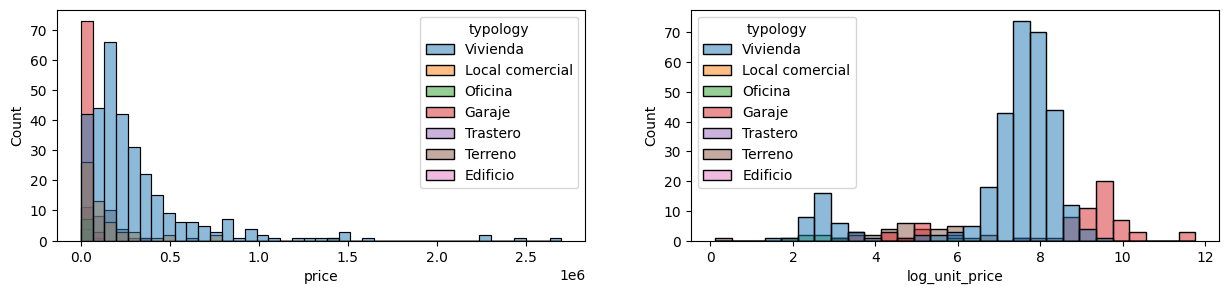

In [36]:
# first plot shows that unit_price and price have logarithmic distribution
_df['log_unit_price'] = _df['unit_price'].apply(lambda cell: np.round(np.log(cell), 4))

_sample = _df.sample(500)
f, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(15,3))

sns.histplot(data=_sample, x = 'price', hue = 'typology', ax=ax[0]) # logarithmic distribution
sns.histplot(data=_sample, x = 'log_unit_price', hue = 'typology', ax=ax[1])

plt.show()

Since the value of a property is related to its typology, the classification is done depending on that:

In [41]:
def classify_property(cell, iqr):

    if cell >= iqr.loc[0.75]:
        return 'over-valued'

    elif cell <= iqr.loc[0.25]:
        return 'under-valued'
    
    else:
        return 'normal'



for _type in _df['typlogy_general'].unique():
    _f = (_df['typlogy_general'] == _type)

    iqr = _df[_f]['unit_price'].quantile((0.25, 0.75))

    _df.loc[_f, 'valuation'] = _df[_f]['unit_price'].apply(
        lambda row: classify_property(row, iqr=iqr)
    )


_df['valuation'].value_counts(normalize=True).apply(lambda c: np.round(c*100, 3))

valuation
normal          57.709
over-valued     21.155
under-valued    21.136
Name: proportion, dtype: float64

In [49]:
pivoted = pd.pivot_table(_df, index ='typology', columns = 'valuation', values = 'customer_id', aggfunc='count', margins=True).iloc[:-1, :]
pivoted = pivoted.apply(lambda row : np.round(row*100 / row['All'], 2), axis= 1).iloc[:, :-1]
pivoted

valuation,normal,over-valued,under-valued
typology,,,
Edificio,50.51,24.75,24.75
Garaje,53.43,23.29,23.28
Local comercial,100.00,NaN,NaN
Oficina,50.70,24.58,24.73
Terreno,54.61,22.70,22.69
Trastero,56.60,21.80,21.61
Vivienda,50.47,24.78,24.75


In [42]:
pivoted = pd.pivot_table(_df, index ='typlogy_general', columns = 'valuation', values = 'customer_id', aggfunc='count', margins=True).iloc[:-1, :]
pivoted = pivoted.apply(lambda row : np.round(row*100 / row['All'], 2), axis= 1).iloc[:, :-1]
pivoted

valuation,normal,over-valued,under-valued
typlogy_general,,,
Edificio,50.51,24.75,24.75
Garaje,53.43,23.28,23.28
Garaje Piso,NaN,100.00,NaN
Local comercial,100.00,NaN,NaN
Local comercial Chalet,100.00,NaN,NaN
Local comercial Nave Industrial,100.00,NaN,NaN
Oficina,50.70,24.58,24.73
Terreno,54.27,22.86,22.86
Terreno Chalet,NaN,100.00,NaN


Which postal code has the most number of opportunities ?

In [54]:
pd.pivot_table(data = _df, index = 'zipcode', columns = 'valuation', aggfunc='count', values = 'customer_id', margins = True).iloc[:-1, :].sort_values(by='under-valued', ascending=False)

valuation,normal,over-valued,under-valued,All
zipcode,,,,
08022,139.0,323.0,568.0,1030
08490,673.0,46.0,502.0,1221
08003,334.0,542.0,456.0,1332
08001,632.0,605.0,433.0,1670
08015,322.0,667.0,369.0,1358
...,...,...,...,...
8918,NaN,6.0,NaN,6
8921,1.0,NaN,NaN,1
8940,3.0,2.0,NaN,5


-----
###
Saving result into a json gzip compressed file

In [44]:
_df.to_json('data/output.json', orient='records', compression='gzip')

----

In [45]:
_df.describe()

,price,bedrooms,bathrooms,area,area_land,is_professional,unit_price,log_unit_price
count,1.223740e+05,122374.000000,122374.000000,1.223740e+05,1.223740e+05,122374.000000,1.033980e+05,103398.0000
mean,9.287925e+05,2.058076,1.109288,4.181751e+02,5.613151e+03,0.925875,4.535509e+03,-inf
std,2.477246e+07,2.076697,1.189478,1.075348e+04,1.808112e+06,0.261976,7.205606e+04,NaN
min,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,-inf
25%,1.350000e+04,0.000000,0.000000,6.000000e+01,0.000000e+00,1.000000,8.605608e+02,6.7576
50%,1.560000e+05,2.000000,1.000000,9.700000e+01,0.000000e+00,1.000000,1.975000e+03,7.5883
75%,3.150000e+05,3.000000,2.000000,2.000000e+02,0.000000e+00,1.000000,3.630769e+03,8.1972
max,1.000000e+09,155.000000,33.000000,1.401450e+06,6.324901e+08,1.000000,1.250000e+07,16.3412


In [46]:
_df['is_professional'].value_counts(normalize=True)

is_professional
1    0.925875
0    0.074125
Name: proportion, dtype: float64

In [47]:
area_corr = dict()

for _typology in _df['typology'].unique():
    area_corr[_typology] = np.round(_df[_df['typology'] == _typology][['area', 'area_land']].corr().iloc[0, 1], 3)

area_corr

{'Vivienda': 0.0,
 'Oficina': -0.036,
 'Terreno': 0.505,
 'Local comercial': 0.116,
 'Garaje': nan,
 'Trastero': 0.141,
 'Edificio': -0.002}

/home/laura/Pruebas/technical_test/.env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


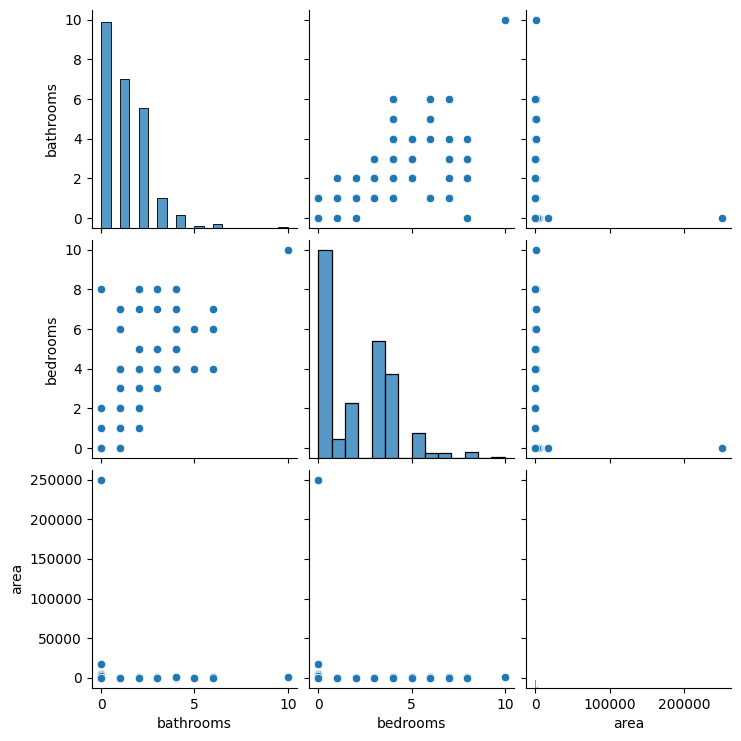

In [48]:
sns.pairplot(_df[['bathrooms', 'bedrooms', 'area']].sample(500))